Projet 5 - Segmentez des clients d'un site e-commerce - Durée de vie du clustering
>-
# 1. Initialisation, visualization

>>-
## 11. Imports

>>>-
### 111. Package imports

In [1]:
import numpy as np              # fast thus always used
import pandas as pd             # fast
pd.set_option("display.max_rows", 20, "display.max_columns", None)
import matplotlib.pyplot as plt # slow: 233 ns
import seaborn as sns           # SLOW BUT: 80.4 ns
sns.set_style("whitegrid")      # "ticks", "white"
import re
import my
import datetime
from scipy import interpolate   # FAST BUT: 319 ns ± 2.64 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
#  %timeit import geopandas     # SLOW 
import timeit
#import os
#import sys
from IPython.display import clear_output
import warnings

In [32]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, adjusted_rand_score

>>>-
### 112. Data imports

In [2]:
dfs1 = pd.read_csv("olist_customers_dataset.csv") #, sep="\t")
dfs2 = pd.read_csv("olist_geolocation_dataset.csv") #, sep="\t")
dfs3 = pd.read_csv("olist_order_items_dataset.csv") #, sep="\t")
dfs4 = pd.read_csv("olist_order_payments_dataset.csv") #, sep="\t")
dfs5 = pd.read_csv("olist_order_reviews_dataset.csv") #, sep="\t")
dfs6 = pd.read_csv("olist_orders_dataset.csv") #, sep="\t")
dfs7 = pd.read_csv("olist_products_dataset.csv") #, sep="\t")
dfs8 = pd.read_csv("olist_sellers_dataset.csv") #, sep="\t")
dfs9 = pd.read_csv('product_category_name_translation.csv') #, sep='\t')
dfs = [dfs1, dfs2, dfs3, dfs4, dfs5, dfs6, dfs7, dfs8, dfs9]

Je ne suis pas très content de cette solution pour pouvoir itérer sur les 9 df car je crée un objet dfs gigantesque, alors que je veux juste une liste qui renvoie vers chacun des 9 df sans contenir leur contenu.

>>>-
### 113. Init

In [41]:
def init_classif_in(df=df, cols_num=["R","F","M","S"], ns=0):
    X = df[cols_num]
    
    if ns:
#        print(X.shape, sum(X.F == 1))
        pct = (1-sum(X.F == 1)/X.shape[0])*100
        print("Il y a {a:.1f}% de clients ayant effectué plus d'un achat "
              "dans le dataset avant subsampling.".format(a=pct))
        X = X.sample(n=ns, weights=None, random_state=1)
                     #frac=.1, weights="F", random_state=1)
#        print(X.shape, sum(X.F == 1))
        pct = (1-sum(X.F == 1)/X.shape[0])*100
        print("Il y a {a:.1f}% de clients ayant effectué plus d'un achat "
              "dans la subsample sélectionnée.".format(a=pct))
    
    return X

>-
# 4. Fabrication des dfs

>>-
## 41. Merge_1

In [3]:
df = dfs1[["customer_id","customer_unique_id"]].merge(dfs6[["customer_id","order_id","order_purchase_timestamp"]], on="customer_id", how="outer")
df = df.merge(dfs4[["order_id","payment_value"]], on="order_id", how="outer")

>>-
## 42. Cleaning_1

In [4]:
new_elt = list(set(df.order_id).difference(set(dfs4.order_id)))

In [5]:
df = df[df.order_id != new_elt[0]]
df = my.resindx(df)

Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(103886, 5)


>>-
## 43. Merge_2

In [6]:
df = df.merge(dfs5[["order_id","review_score"]], on="order_id", how="outer")

>>-
## 44. Cleaning_2 (et re-cleaning_1)

In [7]:
new_elts = list(set(df.order_id).difference(set(dfs5.order_id)))

In [8]:
df = df[df.order_id != new_elt[0]]
df = my.resindx(df)

Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(104477, 6)


In [9]:
df = df[df.review_score.isna() == False]
df = my.resindx(df)

Il n'y avait pas de colonne 'level_0' indésirable à supprimer.
Une colonne 'index' indésirable a été supprimée.
(103677, 6)


>>-
## 45. Feature cleaning

In [10]:
keeps = ["customer_unique_id","order_purchase_timestamp","payment_value","review_score"]
df = df[keeps]

>>-
## 46. Réorganisation RFM + rs

In [11]:
t0 = datetime.datetime.strptime(df.order_purchase_timestamp.max(), "%Y-%m-%d %H:%M:%S")
df["recency_2"] = pd.to_numeric(pd.to_datetime(df.order_purchase_timestamp))
df["recency_2"] = (df.recency_2.max() - df.recency_2)*10**-9

In [12]:
dfs = pd.DataFrame()
dfs["R"] = df.groupby("customer_unique_id").recency_2.min()
dfs["F"] = df.groupby(["customer_unique_id","order_purchase_timestamp"]).agg("count").groupby("customer_unique_id").count().payment_value
dfs["M"] = df.groupby("customer_unique_id").payment_value.sum()
dfs["S"] = df.groupby("customer_unique_id").review_score.min()
dfs.head(2)

,R,F,M,S
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,13847631.0,1,141.90,5.0
0000b849f77a49e4a4ce2b2a4ca5be3f,14105931.0,1,27.19,4.0


In [13]:
print(dfs.shape[0], ", ", sum(dfs.F == 1))
pct = (1-sum(dfs.F == 1)/dfs.shape[0])*100
pct = (sum(dfs.F > 1)/dfs.shape[0])*100 # idem car par construction F < 1 n'existe pas.
print("Il y a {a:.1f}% de clients ayant effectué plus d'un achat dans le dataset avant subsampling.".format(a=pct))

95379 ,  92680
Il y a 2.8% de clients ayant effectué plus d'un achat dans le dataset avant subsampling.


>>-
## 47. Fabrication des dfs

>>>-
### 471. Tests

In [22]:
rcies = pd.DataFrame([df.order_purchase_timestamp.max(),
                     "2018-10-01 00:00:01",
                     "2018-09-17 17:30:18",
                     df.order_purchase_timestamp.min()],
                    columns=["dates"])

,dates
0,2018-10-17 17:30:18
1,2018-10-01 00:00:01
2,2018-09-17 17:30:18
3,2016-09-04 21:15:19


In [23]:
rcies["recencies"] = pd.to_numeric(pd.to_datetime(rcies.dates))
rcies["recencies"] = (rcies.recencies.max() - rcies.recencies)*10**-9
rcies

,dates,recencies
0,2018-10-17 17:30:18,0.0
1,2018-10-01 00:00:01,1445417.0
2,2018-09-17 17:30:18,2592000.0
3,2016-09-04 21:15:19,66773699.0


In [37]:
df_list = []
df_list.append(dfs[dfs.R <    rcies.recencies[1]])
df_list.append(dfs[dfs.R <    rcies.recencies[2]])
df_list.append(dfs[dfs.R <  2*rcies.recencies[2]])
df_list.append(dfs[dfs.R < 12*rcies.recencies[2]]) # Ceux-ci vont me servir
df_list.append(dfs[dfs.R < 13*rcies.recencies[2]]) # Ceux-ci vont me servir
df_list.append(dfs[dfs.R < 14*rcies.recencies[2]]) # Ceux-ci vont me servir
df_list.append(dfs[dfs.R < 15*rcies.recencies[2]]) # Ceux-ci vont me servir
df_list.append(dfs[dfs.R < 16*rcies.recencies[2]]) # Ceux-ci vont me servir
df_list.append(dfs[dfs.R > rcies.recencies[3] - 12*rcies.recencies[2]])
df_list.append(dfs[dfs.R > rcies.recencies[3] -  2*rcies.recencies[2]])
df_list.append(dfs[dfs.R > rcies.recencies[3] -    rcies.recencies[2]])
#for i in range(len(df_list)):
#    sns.scatterplot(df_list[i].R, df_list[i].F, df_list[i].M)

>>>-
### 472. dfs

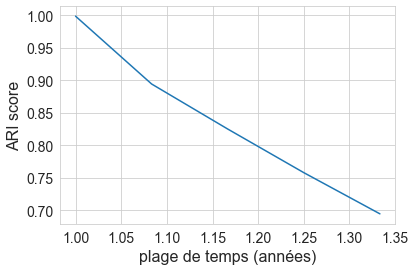

In [55]:
cols_num=["R","F","M","S"]
ARIs = []
tm = 3
tM = 8

X_0 = init_classif_in(df = df_list[3])
scaler_0 = StandardScaler()
scaler_0 = scaler_0.fit(X_0[cols_num])
X_0[cols_num] = scaler_0.transform(X_0[cols_num])
model_0 = KMeans(n_clusters=5, init="k-means++")
model_0 = model.fit(X_0)

for i in range(tm, tM):
    X = init_classif_in(df = df_list[i])
    X_0 = X.copy()
    X_0[cols_num] = scaler_0.transform(X_0[cols_num])
    y0_pred = model_0.predict(X_0)
    
    scaler = StandardScaler()
    X[cols_num] = scaler.fit_transform(X[cols_num])
    model = KMeans(n_clusters=5, init="k-means++")
    model = model.fit(X)
    y_pred= model.predict(X)
    
    ARIs.append(adjusted_rand_score(y0_pred, y_pred))
    
dt = pd.Series(range(tM-tm))
dt = 1+dt/12
fig = plt.figure(figsize=(6, 4))
plt.plot(dt, ARIs)
#plt.title("ARI score")
plt.xlabel("plage de temps (années)",fontsize=16)
plt.xticks(fontsize=14)
plt.ylabel("ARI score",fontsize=16)
plt.yticks(fontsize=14)
print("")